## Feature Extraction, New and Improved

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from pathlib import Path
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
from scipy.fftpack import fft, dct

---

## Visualize audio data with librosa

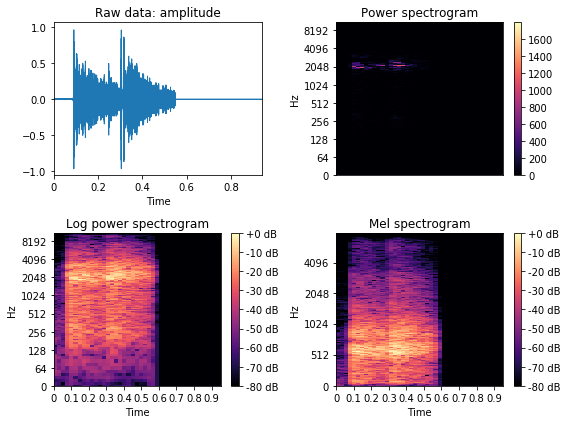

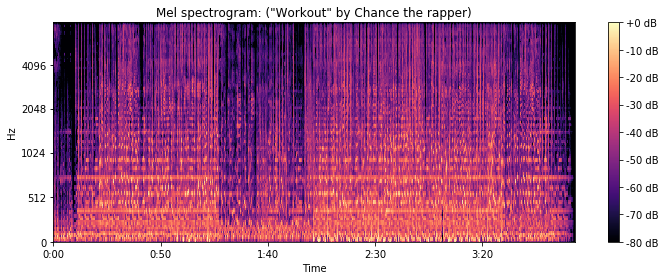

In [16]:
y, sr = librosa.load('../../../Source/Clean_train_clips/Train_augment_pad/Shuffle/1/1_.wav')
D = np.abs(librosa.stft(y))

# Using left-aligned frames
D_left = np.abs(librosa.stft(y,center=False))

# Using a shorter hop length
n_fft = 20 # default 2048
D_short = np.abs(librosa.stft(y, n_fft=n_fft,hop_length=64)) # defaults to win_length(or n_fft)/4.



#librosa.display.specshow(D_left);
#librosa.display.specshow(D_short);

# Wave plot
plt.figure(figsize=(8,6))
plt.subplot(221)
librosa.display.waveplot(y, sr=sr)
plt.title('Raw data: amplitude')

# Power spectrogram with abs(stft(y))^2
plt.subplot(222)
librosa.display.specshow(D**2, sr=sr, y_axis='log')
plt.colorbar()
plt.title('Power spectrogram')

# Log power with power_to_db
plt.subplot(223)
librosa.display.specshow(librosa.power_to_db(D**2,ref=np.max),sr=sr, y_axis='log', x_axis='time')
plt.title('Log power spectrogram')
plt.colorbar(format='%+2.0f dB')

# Mel spectrogram 
plt.subplot(224)
librosa.display.specshow(librosa.power_to_db(D**2,ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram');
plt.tight_layout()



y, sr = librosa.load('../../../workout.wav')
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D)


plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=S,ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram: ("Workout" by Chance the rapper)')
plt.tight_layout()

---

# Feature Extraction: exploration
## Tempo

Let's try it with a stretched and unstretched sample

In [4]:
fast_clip = ('../../../Source/Clean_train_clips/Shuffle/1/1.wav')
slow_clip = ('../../../Source/Clean_train_clips/Augmented/Shuffle/1/1_stretch.wav') 

In [5]:
def get_features_bpm(path): 
    samples, sample_rate = librosa.load(path)
    onset_env = librosa.onset.onset_strength(samples, sr=sample_rate) # Assumes static tempo, for dynamic: aggregate=None
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sample_rate)
    return tempo.item()


In [6]:
get_features_bpm(slow_clip), get_features_bpm(fast_clip)

(129.19921875, 258.3984375)

## Short-time Fourier transform (STFT)

From librosa documentation: <br/>
Returns a complex-valued matrix D such that
np.abs(D[f, t]) is the magnitude of frequency bin f at frame t
 <br/><br/>***Why?***<br/>
 This transformation allows us to capture information or patterns in the signal's frequency in discrete, short windows of time. By placing them next to one another, we can visualize the signal's frequency as it changes over time (spectrogram)

In [20]:
n_fft = 256 # default 2048
win_length = n_fft  # default n_fft
hop_length = int(win_length/2)  # default win_length/4
window = 'hann'  # default hanning window

In [21]:
def get_features_stft (path):
        y, sr = librosa.load(path)
        D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window))
        return D

In [22]:
y, sr = librosa.load('../../../Source/Clean_train_clips/Train_augment_pad/Shuffle/1/1_.wav')
D = get_features_stft('../../../Source/Clean_train_clips/Train_augment_pad/Shuffle/1/1_.wav')
print('Shape of STFT output: ' ,D.shape)
print('How did we get that?')
print ('1 + n_fft/2 = ', int(1+n_fft/2))
print ('len(signal)/n_fft * 2 + 1 = ', int(len(y)/256 *2 +1))

Shape of STFT output:  (129, 163)
How did we get that?
1 + n_fft/2 =  129
len(signal)/n_fft * 2 + 1 =  163


Linear-frequency power spectrogram for two different steps


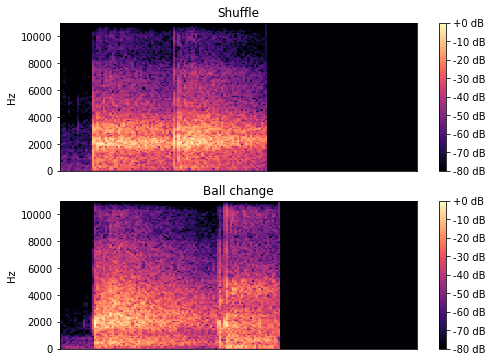

In [23]:
S_1 = get_features_stft('../../../Source/Clean_train_clips/Train_augment_pad/Shuffle/1/1_.wav')
S_2 = get_features_stft('../../../Source/Clean_train_clips/Train_augment_pad/Ball_change/1/3_.wav')

D_1 = librosa.power_to_db(S_1**2, ref=np.max)
D_2 = librosa.power_to_db(S_2**2, ref=np.max)

plt.figure(figsize=(8,6))

plt.subplot(211)
librosa.display.specshow(D_1, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Shuffle')

plt.subplot(212)
librosa.display.specshow(D_2, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Ball change')

print('Linear-frequency power spectrogram for two different steps')

## Mel-frequency cepstral coefficients 

In [7]:
n_mfcc = 20 

In [8]:
def get_features_mfcc(path):
    samples, sample_rate = librosa.load(path)
    mfccs = np.mean(librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=n_mfcc).T,axis=0)
    return mfccs

## Zero crossing rate


In [9]:
def get_features_ZCR(path):
    samples, sample_rate = librosa.load(path)
    return librosa.feature.zero_crossing_rate(samples, frame_length=256, hop_length=128)

In [10]:
example_path = ('../../../Source/Clean_train_clips/Train_augment_pad/Shuffle/1/1_.wav')

In [11]:
zcr_length = get_features_ZCR(example_path).shape[1]

## Energy and Root Mean Square Energy

In [24]:
x, sr = librosa.load('../../../Source/Clean_train_clips/Train_augment_pad/Shuffle/1/1_.wav')
print ('Duration in sec: ' + str(librosa.core.get_duration(x,sr)))
print('Length of sample: ' + str(len(x)))

Duration in sec: 0.9420408163265306
Length of sample: 20772


In [25]:
hop_length = 128
frame_length = 256

In [26]:
def get_features_energy(path) :
    samples, sample_rate = librosa.load(path)
    energy = np.array([sum(abs(samples[i:i+frame_length]**2)) for i in range (0, len(samples), hop_length)])
    return energy

def get_features_rmse(path):
    samples, sample_rate = librosa.load(path)
    rmse = librosa.feature.rmse(samples, frame_length=frame_length, hop_length=hop_length, center=True)
    return rmse[0]

In [27]:
# Could this be an option to reduce features? Does this make sense?

#frame_length = int(len(x))
#hop_length = int(frame_length/2)
#print (frame_length, hop_length)
#get_features_energy('../../../Source/Clean_train_clips/Re_augmented_pad/Shuffle/1/5_.wav')

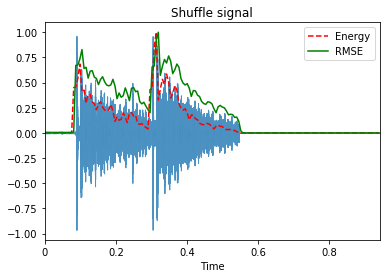

In [28]:
# So the shape of the energy and RMSE is the result of # of samples / (frame_length/2) +1

energy = get_features_energy('../../../Source/Clean_train_clips/Train_augment_pad/Shuffle/1/1_.wav')
rmse = get_features_rmse('../../../Source/Clean_train_clips/Train_augment_pad/Shuffle/1/1_.wav')
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length) # Why?
## Visualization
#plt.figure(figsize=(8,6))
librosa.display.waveplot(x, sr=sr, alpha=0.8)
plt.plot(t, energy/energy.max(), 'r--')             # normalized for visualization
plt.plot(t[:len(rmse)], rmse/rmse.max(), color='g') # normalized for visualization
plt.legend(('Energy', 'RMSE'))
plt.title('Shuffle signal');


---

## Feature Extraction: implementation
(Organized in a DataFrame)

In [2]:
def build_list(step, folder, length):
    i = 1
    step_list = []
    while i <= length :
        name = step + "/" + str(folder) + "/" +str(i) + ".wav"
        step_list.append(name)
        i += 1
    return step_list

def get_label(path):
    if path.parts[-3] == 'Shuffle':
        return 1
    else:
        return 0

---

### Load Train, Validate, or Test Data

In [3]:
path_col = []

In [4]:
# Train 
pathlist = Path('../../../Source/Clean_train_clips/Train_augment_pad').glob('**/*.wav')
for path in pathlist:
    path_col.append(path)

In [ ]:
# Validate
#pathlist = Path('../../../Source/Clean_train_clips/Validate_pad').glob('**/*.wav')
#for path in pathlist:
#    path_col.append(path)

In [ ]:
# Test
#pathlist = Path('../../../Source/Clean_train_clips/Test_pad').glob('**/*.wav')
#for path in pathlist:
#    path_col.append(path)

In [5]:
len(path_col)  # Train: 916 , Validate: 38 , Test: 76

916

** Create DataFrame from file paths **

In [6]:
tap = pd.DataFrame({'Path':path_col})
tap.shape

(916, 1)

---

**Add labels**

In [7]:
tap['Labels'] = [get_label(tap.loc[idx,'Path']) for idx in range(len(tap))]

In [8]:
tap.head()

Path  Labels
0  ../../../Source/Clean_train_clips/Train_augmen...       0
1  ../../../Source/Clean_train_clips/Train_augmen...       0
2  ../../../Source/Clean_train_clips/Train_augmen...       0
3  ../../../Source/Clean_train_clips/Train_augmen...       0
4  ../../../Source/Clean_train_clips/Train_augmen...       0

** Empty Dataframe to fill**

---

# CNN is more than *fake news*

In [9]:
# Create an empty dataframe to fill with raw signal data

d = pd.DataFrame(np.zeros((len(tap), 20772)))
tap = pd.concat([tap, d], axis=1)

In [11]:
# Raw data for CNN

for j in range (len(tap))  :  
    y, sr = librosa.load(tap.loc[j,'Path'])
    for i in range (20772):
        tap.iat[j,i+2] = y.item(i)




In [13]:
tap.head()
#tap.to_csv('../../../Source/Data/train_data_signal.csv', index=None)

X = tap.drop(['Labels'], axis =1)
y = tap[['Labels']]

X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

# Export inputs and targets

#X_df.to_csv('../../../Source/Data/X_train_signal.csv', index=None)
#y_df.to_csv('../../../Source/Data/y_train_signal.csv', index=None)




---

In [ ]:
# Create an empty dataframe to fill with multiple feature values
# mfcc: 20, zcr/rmse/energy: 163 each

d = pd.DataFrame(np.zeros((len(tap), int(n_mfcc+zcr_length*3))))
tap = pd.concat([tap, d], axis=1)

In [ ]:
print(tap.shape)
2+20+163+163+163

**Add Features: MFCCs**

In [ ]:
# TOO SLOW!
#for i in range (n_mfcc):
#    tap[str(i)] = [get_features_mfcc(tap.loc[idx, 'Path'])[i] for idx in range (len(tap))]

In [ ]:
# Add feature to DataFrame
for j in range (len(tap))  :  
    s = get_features_mfcc(tap.loc[j,'Path'])
    for i in range (n_mfcc):
        tap.iat[j,i+2] = s[i]

In [ ]:
tap.head()
#tap.iloc[:,20:]
#tap.iat[0,0+22]

** Add Features: Tempo**

In [ ]:
tap['BPM'] = [get_features_bpm(tap.loc[idx, 'Path']) for idx in range (len(tap))]

In [ ]:
tap.head()

** Add features: Zero-crossing rate**

In [ ]:
for j in range (len(tap))  :  
    s = get_features_ZCR(tap.loc[j,'Path'])[0]
    for i in range (zcr_length):
        tap.iat[j,i+22] = s.item(i)

In [ ]:
tap.head()
tap.shape
#tap.iloc[:,20:]

**Add features: Short-time Fourier Transform**

In [ ]:
#for j in range (len(tap))  :  
#    s = get_features_stft(tap.loc[j,'Path'])[0]
#    for i in range (int(n_fft/2+1)):
#        tap.iat[j,i+2] = s.item(i)

In [ ]:
#tap.head()
#2+20+zcr_length

**Add Features: Energy **

In [ ]:
for j in range (len(tap))  :  
    s = get_features_energy(tap.loc[j,'Path'])
    for i in range (zcr_length):
        tap.iat[j,i+185] = s.item(i)

In [ ]:
#tap.iloc[:,155:185]
tap.head()

**Add Features: Root mean square energy **

In [ ]:
for j in range (len(tap))  :  
    s = get_features_rmse(tap.loc[j,'Path'])
    for i in range (int(len(x)/(frame_length/2)+1)):
        tap.iat[j,i+348] = s.item(i)

In [ ]:
tap.head()
348+zcr_length

----

### Export Feature DataFrame

In [ ]:
tap = tap.sample(frac=1)
tap.head()

In [ ]:
# Inputs and targets (complete DataFrame)
#tap.to_csv('../../../Source/Data/test_data_mfcc_zcr_energy_rmse_bpm.csv', index=None)


### Split into inputs and labels (and train and validate)

In [ ]:
X = tap.drop(['Labels'], axis =1)
y = tap[['Labels']]

In [ ]:
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

In [ ]:
# Export inputs and targets

#X_df.to_csv('../../../Source/Data/X_test_mfcc_zcr_energy_rmse_bpm.csv', index=None)
#y_df.to_csv('../../../Source/Data/y_test_mfcc_zcr_energy_rmse_bpm.csv', index=None)



## TBD "Features"

**Add features: Fast Fourier Transform**

In [ ]:
def get_features_fft(path):
    y, sr = librosa.load(path)
    return np.mean(fft(y).real)

#tap['FFT'] = [get_features_fft(tap.loc[idx, 'Path']) for idx in range (len(tap))]

**Add features: Discrete cosine transform**

In [ ]:
def get_features_dct(path):
    y, sr = librosa.load(path)
    return (dct(y))

#tap['DCT'] = [get_features_dct(tap.loc[idx, 'Path']) for idx in range (len(tap))]

**Other (maybe useful) stuff from librosa**

In [ ]:
librosa.core.get_duration(y=y, sr=sr) # Get duration in seconds

** Other code to consider/incorporate ** 

In [ ]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=20).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

## Trying out stuff

In [ ]:
# Can I make a better graph by splitting differently? 
# Tested out in Data_Collection_Audio, ultimately ending with detect nonsilence method, then padding
samples, sample_rate = librosa.load('../../../Source/Shuffle_test/1/1.wav')
librosa.display.waveplot(samples, sr=sample_rate);



In [ ]:
# Pad with silence
padded_signal = librosa.util.pad_center(samples, 22050, axis=0) # Make clip 1 sec long
sound_clip = padded_signal
librosa.display.waveplot(sound_clip, sr=sample_rate);
#librosa.output.write_wav('../../../Source/Shuffle_test/1/1_pad.wav', padded_signal, 22050)

In [ ]:
def windows(data, window_size):
    start=0
    while start < len(data):
        yield start, start + window_size
        start += (window_size/2)

In [ ]:
i = 0
for (start, end) in windows(sound_clip, window_size):
    i +=1
print(i)

In [ ]:
log_specgrams = []
window_size = 100 * 60
sound_clip = padded_signal
bands = 41
frames = 60

In [ ]:
for (start, end) in windows(sound_clip, window_size):
    if len(sound_clip[int(start):int(end)]) == (window_size):
        signal = sound_clip[int(start):int(end)]
        melspec = librosa.feature.melspectrogram(signal,n_mels=bands)
        logspec = librosa.amplitude_to_db(melspec)
        logspec = logspec.T.flatten()[:, np.newaxis].T
        log_specgrams.append(logspec)
        
log_specgrams = np.array(log_specgrams)
print(log_specgrams.shape) #  This is (# of complete windows, 1, # of bands)
#log_specgrams = np.asarray(log_specgrams).reshape(log_specgrams.shape[0], bands, frames)

